# Modular Quantitative Research Workflow in Algorithmic Trading  
## From Data to Deployed Strategy (SPY Example)

In this notebook we will walk through a **modular quantitative research pipeline** similar to what you see in:

- *Systematic Trading* — Robert Carver  
- *Advances in Financial Machine Learning* — Marcos López de Prado  
- *Machine Learning for Trading* — Stefan Jansen  

Our goal is to show a **practical, end-to-end example** on a single asset (SPY ETF):

1. **Data Curation**  
   - Download historical data (OHLCV) using `yfinance`  
   - Briefly discuss cleaning / adjustments

2. **Data Labeling (López de Prado style)**  
   - Implement a simplified **triple-barrier labeling** scheme  
   - This turns raw prices into learnable labels (+1, 0, −1)

3. **Predictive Model**  
   - Engineer simple features  
   - Train a **Random Forest classifier** to predict label (+1 / −1 / 0)

4. **Strategy Construction**  
   - Convert model predictions into trading positions (long/short/flat)  
   - Simple risk control via position scaling / thresholds

5. **Backtesting & Evaluation**  
   - Run a vectorized backtest  
   - Plot equity curve & drawdowns  
   - Compute basic performance statistics (Sharpe, max drawdown, hit rate)

This is **not** meant to be production-ready, but rather:

- A didactic example of a **modular research framework**  
- A template you can reuse and extend for more assets, more features, and better models

---


In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Data
import yfinance as yf

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Curation

In a real research environment, **data curation** consumes a huge amount of time:

- Collecting data (trades, quotes, fundamentals, alternative data)
- Cleaning outliers and obvious data errors
- Adjusting for corporate actions (splits, dividends, mergers)
- Ensuring there is **no look-ahead bias** (you only use information that would have been available at the time)
- Ensuring **no survivorship bias** (you include delisted / dead assets)

In this example, we will:

- Use `yfinance` to download **SPY (S&P 500 ETF)** daily OHLCV data.
- Rely on the fact that `yfinance` already gives us **adjusted close prices** (adjusted for splits and dividends).
- Keep curation minimal, but point out where deeper cleaning would be needed in a real project.

This is a **single-asset** example for teaching. In practice, you would generalize this to **many tickers** and build a panel dataset.

In [3]:
# Download SPY daily data
ticker = "SPY"
start_date = "2005-01-01"
end_date = None  # up to latest available

data = yf.download(ticker, start=start_date, end=end_date)

# Basic check
data.head()

C:\Users\boleb\AppData\Local\Temp\ipykernel_32144\2331433702.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2005-01-03,81.847122,82.840445,81.574978,82.704370,55748000
2005-01-04,80.846977,82.010389,80.581638,81.955959,69167600
2005-01-05,80.289116,81.132759,80.282311,80.785775,65667300
2005-01-06,80.697334,81.064729,80.459210,80.581675,47814700
2005-01-07,80.581657,81.119141,80.370743,80.942247,55847700


In [5]:
import pandas as pd

# If there are any NaNs, drop them
data = data.dropna()

# Handle both single-ticker and multi-ticker outputs from yfinance
if isinstance(data.columns, pd.MultiIndex):
    # MultiIndex case, e.g. columns like ('Open', 'SPY')
    first_ticker = data.columns.levels[1][0]

    close_series = data["Close"][first_ticker]

    # Use Adj Close if it exists, otherwise fall back to Close
    if ("Adj Close", first_ticker) in data.columns:
        adj_close_series = data["Adj Close"][first_ticker]
    else:
        adj_close_series = close_series

    data = pd.DataFrame({
        "open":      data["Open"][first_ticker],
        "high":      data["High"][first_ticker],
        "low":       data["Low"][first_ticker],
        "close":     close_series,
        "adj_close": adj_close_series,
        "volume":    data["Volume"][first_ticker],
    })

else:
    # Single-index columns, e.g. ['Open', 'High', 'Low', 'Close', 'Volume']
    close_series = data["Close"]

    # Use Adj Close if it exists, otherwise fall back to Close
    if "Adj Close" in data.columns:
        adj_close_series = data["Adj Close"]
    else:
        adj_close_series = close_series

    data = pd.DataFrame({
        "open":      data["Open"],
        "high":      data["High"],
        "low":       data["Low"],
        "close":     close_series,
        "adj_close": adj_close_series,
        "volume":    data["Volume"],
    })

print("Columns after standardisation:", data.columns)
data.head()



Columns after standardisation: Index(['open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')


,open,high,low,close,adj_close,volume
Date,,,,,,
2005-01-03,82.704370,82.840445,81.574978,81.847122,81.847122,55748000
2005-01-04,81.955959,82.010389,80.581638,80.846977,80.846977,69167600
2005-01-05,80.785775,81.132759,80.282311,80.289116,80.289116,65667300
2005-01-06,80.581675,81.064729,80.459210,80.697334,80.697334,47814700
2005-01-07,80.942247,81.119141,80.370743,80.581657,80.581657,55847700


## 2. Data Labeling (Triple-Barrier Method)

Now we transform raw prices into **labels** that our model can learn.

Following the spirit of **López de Prado's triple-barrier method**:

- For each time \( t \), we set:
  - An **upper price barrier** (profit-taking level)
  - A **lower price barrier** (stop-loss level)
  - A **time barrier** (maximum holding period in days)

Then we look forward in time from \( t \):

- If the **upper barrier** is hit first → label = **+1**
- If the **lower barrier** is hit first → label = **−1**
- If neither barrier is hit before the time barrier → label = **0** (“uncertain / no strong signal”)

In full AFML style, barrier sizes depend on **volatility**.  
Here we implement a **simplified version**:

1. Compute a daily volatility estimate from returns.
2. For each day, set:
   - Upper barrier: \( P_t \cdot (1 + m \cdot \sigma_t) \)
   - Lower barrier: \( P_t \cdot (1 - m \cdot \sigma_t) \)
   - Time barrier: \( T \) days ahead

This provides **classification labels** that encode a directional view with risk bounds.

In [6]:
def get_daily_vol(close, span=50):
    """
    Estimate daily volatility using exponentially weighted moving std
    of daily log returns.
    """
    log_ret = np.log(close / close.shift(1))
    vol = log_ret.ewm(span=span).std()
    return vol


def apply_triple_barrier(close, daily_vol, pt_mult=1.0, sl_mult=1.0, max_holding=10):
    """
    Simplified triple-barrier labeling.
    
    Parameters
    ----------
    close : pd.Series
        Close prices.
    daily_vol : pd.Series
        Daily volatility estimate (e.g., from get_daily_vol).
    pt_mult : float
        Profit-take barrier multiple of volatility.
    sl_mult : float
        Stop-loss barrier multiple of volatility.
    max_holding : int
        Maximum holding period in days (time barrier).
    
    Returns
    -------
    labels : pd.Series
        +1 if upper barrier hit first
        -1 if lower barrier hit first
        0 otherwise (no barrier hit before time limit)
    """
    close = close.copy()
    daily_vol = daily_vol.copy()
    labels = pd.Series(index=close.index, dtype="float64")
    
    for t in range(len(close) - max_holding):
        start_idx = close.index[t]
        price_t = close.iloc[t]
        vol_t = daily_vol.iloc[t]
        
        if np.isnan(vol_t):
            labels.iloc[t] = np.nan
            continue
        
        # Set barriers
        pt = price_t * (1 + pt_mult * vol_t)
        sl = price_t * (1 - sl_mult * vol_t)
        
        # Look forward up to max_holding days
        future_prices = close.iloc[t + 1 : t + 1 + max_holding]
        hit_pt = (future_prices >= pt).idxmax() if (future_prices >= pt).any() else None
        hit_sl = (future_prices <= sl).idxmax() if (future_prices <= sl).any() else None
        
        # Decide which barrier hit first
        if hit_pt is not None and hit_sl is not None:
            # Both hit; check which came first
            if hit_pt < hit_sl:
                labels.iloc[t] = 1
            elif hit_sl < hit_pt:
                labels.iloc[t] = -1
            else:
                labels.iloc[t] = 0  # rare tie
        elif hit_pt is not None:
            labels.iloc[t] = 1
        elif hit_sl is not None:
            labels.iloc[t] = -1
        else:
            labels.iloc[t] = 0  # neither barrier hit before time limit
    
    # Last max_holding points cannot be labeled (no full lookahead window)
    labels.iloc[-max_holding:] = np.nan
    
    return labels


In [7]:
# 1. Compute daily volatility from adjusted close
data["daily_vol"] = get_daily_vol(data["adj_close"], span=50)

# 2. Apply triple-barrier labeling
data["label"] = apply_triple_barrier(
    close=data["adj_close"],
    daily_vol=data["daily_vol"],
    pt_mult=1.0,   # profit-take multiple
    sl_mult=1.0,   # stop-loss multiple
    max_holding=10 # time barrier in days
)

# Drop rows without labels (NaN)
data = data.dropna(subset=["label"])

data[["adj_close", "daily_vol", "label"]].head(15)



,adj_close,daily_vol,label
Date,,,
2005-01-05,80.289116,0.003798,1.0
2005-01-06,80.697334,0.008933,-1.0
2005-01-07,80.581657,0.007386,1.0
2005-01-10,80.962677,0.007417,-1.0
2005-01-11,80.404755,0.006908,1.0
2005-01-12,80.670090,0.006692,-1.0
2005-01-13,80.023773,0.006560,1.0
2005-01-14,80.445587,0.006704,1.0
2005-01-18,81.282410,0.007480,-1.0


## 3. Feature Engineering & Predictive Model

Now we build a **predictive model** that tries to forecast the triple-barrier label (+1 / 0 / −1).

For teaching purposes we keep features simple:

- **Past returns** (1-day, 5-day, 10-day)
- **Moving averages** (10-day, 20-day)
- **Volatility** (daily_vol)

These are basic **price-based technical features**, but they’re enough to demonstrate:

- How to structure features in a time-series context (no look-ahead)
- How to train a model on historical data
- How to prevent information leakage by using a **time-based split** (train on the past, test on the future)

We will:

1. Build a feature matrix `X` and label vector `y`.
2. Split data into **train** and **test** by date (no shuffling).
3. Train a `RandomForestClassifier`.
4. Examine classification report and confusion matrix.


In [8]:
# Simple technical features
data["ret_1d"] = data["adj_close"].pct_change(1)
data["ret_5d"] = data["adj_close"].pct_change(5)
data["ret_10d"] = data["adj_close"].pct_change(10)

data["ma_10"] = data["adj_close"].rolling(10).mean()
data["ma_20"] = data["adj_close"].rolling(20).mean()
data["ma_ratio_10_20"] = data["ma_10"] / data["ma_20"]

# Drop initial NaNs
feature_cols = ["ret_1d", "ret_5d", "ret_10d", "daily_vol", "ma_ratio_10_20"]
data = data.dropna(subset=feature_cols + ["label"])

X = data[feature_cols]
y = data["label"].astype(int)

X.head()


,ret_1d,ret_5d,ret_10d,daily_vol,ma_ratio_10_20
Date,,,,,
2005-02-02,0.003027,0.017401,0.008882,0.006039,0.996518
2005-02-03,-0.002599,0.013029,0.012425,0.005870,0.997353
2005-02-04,0.010676,0.023844,0.029543,0.006276,0.999590
2005-02-07,-0.001331,0.016164,0.030202,0.006088,1.001878
2005-02-08,0.001166,0.010932,0.028491,0.005894,1.004180


In [10]:
# Time-based split: train on earlier period, test on later period
split_date = "2015-01-01"
train_mask = X.index < split_date
test_mask = X.index >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train.shape, X_test.shape


((2496, 5), (2727, 5))

In [11]:
# Train RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_clf.fit(X_train, y_train)

# Predictions on test set
y_pred = rf_clf.predict(X_test)

print("Classification report (test period):")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report (test period):
              precision    recall  f1-score   support

          -1       0.36      0.16      0.22      1044
           0       0.00      0.00      0.00       103
           1       0.58      0.82      0.68      1580

    accuracy                           0.54      2727
   macro avg       0.31      0.33      0.30      2727
weighted avg       0.47      0.54      0.48      2727

Confusion matrix:
[[ 168    0  876]
 [  25    0   78]
 [ 279    0 1301]]


c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

## 4. Strategy Construction

We now convert the **model predictions** into a **trading strategy**.

### 4.1. From predictions to trading signals

Our classifier predicts one of three labels:

- **+1** : upper barrier hit first (bullish)
- **−1** : lower barrier hit first (bearish)
- **0**  : neither barrier (uncertain)

We will:

1. Use the model to estimate **class probabilities** \\( P(y = -1), P(y = 0), P(y = 1) \\).
2. Convert these into a **directional score**:
   \\[
   s_t = P(y=1) - P(y=-1)
   \\]
3. Map this score into a position:
   - If \\( s_t > \theta \\) → **long** (position +1)
   - If \\( s_t < -\theta \\) → **short** (position −1)
   - Otherwise → **flat** (0)

Here \\( \theta \\) is a confidence threshold (e.g. 0.1).

### 4.2. Avoiding look-ahead in trading

Important:

- The position for day \( t+1 \) must be based on information **up to day \( t \)**.
- So we:
  - Use feature values at date \( t \)
  - Compute prediction for date \( t \)
  - Apply position starting at \( t+1 \)

This ensures we’re not cheating (no look-ahead).


In [12]:
# Predict class probabilities on *full* dataset (we'll only trade in test period)
proba = rf_clf.predict_proba(X)

# Map probabilities to score s_t = P(+1) - P(-1)
# Find which column corresponds to class +1 / -1
classes = rf_clf.classes_
idx_neg1 = np.where(classes == -1)[0][0]
idx_zero = np.where(classes == 0)[0][0]
idx_pos1 = np.where(classes == 1)[0][0]

score = proba[:, idx_pos1] - proba[:, idx_neg1]

data["score"] = pd.Series(score, index=X.index)

# Position based on threshold
threshold = 0.1
data["raw_position"] = 0
data.loc[data["score"] > threshold, "raw_position"] = 1
data.loc[data["score"] < -threshold, "raw_position"] = -1

# Shift position by 1 day to avoid look-ahead
data["position"] = data["raw_position"].shift(1).fillna(0)

data[["adj_close", "score", "raw_position", "position"]].tail()


,adj_close,score,raw_position,position
Date,,,,
2025-10-29,687.390015,0.049370,0,1.0
2025-10-30,679.830017,0.125063,1,0.0
2025-10-31,682.059998,0.328203,1,1.0
2025-11-03,683.340027,0.364831,1,1.0
2025-11-04,675.239990,0.370441,1,1.0


## 5. Backtesting & Evaluation

We now evaluate the strategy in the **test period** only, to approximate forward performance.

### 5.1. Basic backtest logic (single asset, daily bars)

For each day:

- We hold position \( p_t \) (−1, 0, +1).
- The next day's return is:
  \\[
  r_{t+1} = \frac{P_{t+1}}{P_t} - 1
  \\]
- Strategy return:
  \\[
  R_{t+1}^{\text{strategy}} = p_t \cdot r_{t+1}
  \\]

We then:

- Compute cumulative equity curve.
- Compute performance statistics (Sharpe ratio, max drawdown, hit rate).
- Plot:
  - SPY buy-and-hold vs strategy equity
  - Drawdowns of the strategy

Note: we ignore transaction costs here for simplicity. You can easily add:

- A fixed cost per trade
- A slippage model proportional to turnover


In [13]:
# Compute daily returns on SPY
data["ret"] = data["adj_close"].pct_change()

# Strategy return: position_{t} * ret_{t+1}
data["strategy_ret"] = data["position"] * data["ret"]

# Focus on test period only for evaluation
test_data = data.loc[X_test.index]

test_data[["adj_close", "position", "ret", "strategy_ret"]].head()


,adj_close,position,ret,strategy_ret
Date,,,,
2015-01-02,171.093704,1.0,-0.000535,-0.000535
2015-01-05,168.003769,1.0,-0.018060,-0.018060
2015-01-06,166.421371,1.0,-0.009419,-0.009419
2015-01-07,168.495178,1.0,0.012461,0.012461
2015-01-08,171.485107,1.0,0.017745,0.017745


In [14]:
def sharpe_ratio(returns, periods_per_year=252):
    mean_ret = returns.mean()
    vol_ret = returns.std()
    if vol_ret == 0:
        return np.nan
    return np.sqrt(periods_per_year) * mean_ret / vol_ret


def max_drawdown(equity_curve):
    """
    equity_curve: pd.Series of cumulative equity (e.g., 1 + cumulative returns)
    """
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1.0
    return drawdown.min(), drawdown


# Build equity curves
test_data["bh_equity"] = (1 + test_data["ret"]).cumprod()
test_data["strat_equity"] = (1 + test_data["strategy_ret"]).cumprod()

# Stats
sharpe = sharpe_ratio(test_data["strategy_ret"].dropna())
bh_sharpe = sharpe_ratio(test_data["ret"].dropna())

mdd, dd_series = max_drawdown(test_data["strat_equity"])
bh_mdd, bh_dd_series = max_drawdown(test_data["bh_equity"])

hit_rate = (test_data["strategy_ret"] > 0).mean()

print(f"Strategy Sharpe (test):      {sharpe:.2f}")
print(f"Buy & Hold Sharpe (test):    {bh_sharpe:.2f}")
print(f"Strategy Max Drawdown:       {mdd:.2%}")
print(f"Buy & Hold Max Drawdown:     {bh_mdd:.2%}")
print(f"Strategy Hit Rate (test):    {hit_rate:.2%}")


Strategy Sharpe (test):      1.20
Buy & Hold Sharpe (test):    0.80
Strategy Max Drawdown:       -18.91%
Buy & Hold Max Drawdown:     -33.72%
Strategy Hit Rate (test):    39.09%


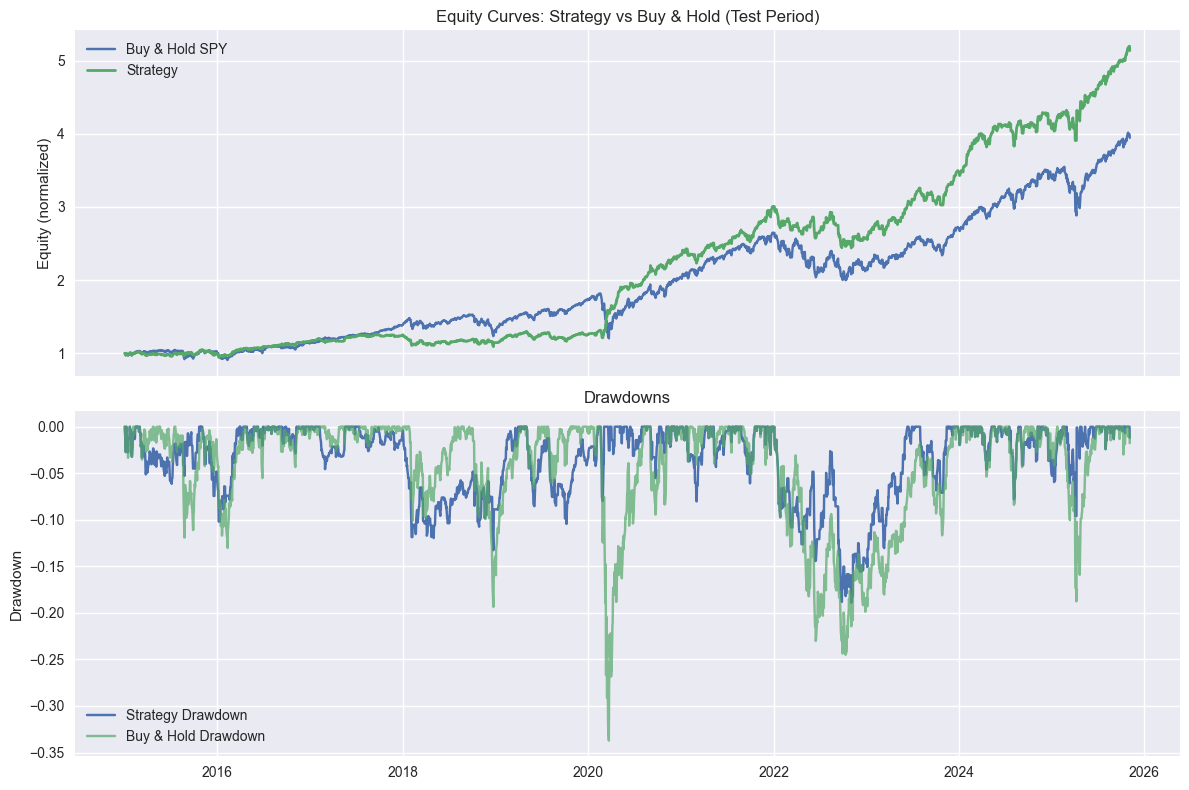

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Equity curves
axes[0].plot(test_data.index, test_data["bh_equity"], label="Buy & Hold SPY")
axes[0].plot(test_data.index, test_data["strat_equity"], label="Strategy", linewidth=2)
axes[0].set_ylabel("Equity (normalized)")
axes[0].set_title("Equity Curves: Strategy vs Buy & Hold (Test Period)")
axes[0].legend()

# Drawdowns
axes[1].plot(test_data.index, dd_series, label="Strategy Drawdown")
axes[1].plot(test_data.index, bh_dd_series, label="Buy & Hold Drawdown", alpha=0.7)
axes[1].set_ylabel("Drawdown")
axes[1].set_title("Drawdowns")
axes[1].legend()

plt.tight_layout()
plt.show()


In [17]:
import vectorbt as vbt

In [18]:
# Restrict to test period (same as X_test)
test_index = X_test.index

price_test = data.loc[test_index, "adj_close"]
position_test = data.loc[test_index, "position"].fillna(0)

# Build entry/exit signals from the desired position series
# Long when position == 1, short when position == -1, flat when 0.

pos = position_test.astype(int)

long_entries  = (pos == 1) & (pos.shift(1).fillna(0) != 1)
long_exits    = (pos != 1) & (pos.shift(1).fillna(0) == 1)

short_entries = (pos == -1) & (pos.shift(1).fillna(0) != -1)
short_exits   = (pos != -1) & (pos.shift(1).fillna(0) == -1)

# Run vectorbt portfolio from signals
pf = vbt.Portfolio.from_signals(
    close=price_test,
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    init_cash=100_000,
    fees=0.0005,     # 5 bps per trade
    slippage=0.0005, # 5 bps slippage
    direction="both",
)

# Buy & hold benchmark on same period
bh_pf = vbt.Portfolio.from_holding(
    close=price_test,
    init_cash=100_000,
)

pf_stats = pf.stats()
bh_stats = bh_pf.stats()

print("=== Strategy stats (test period) ===")
display(pf_stats)

print("\n=== Buy & Hold SPY stats (test period) ===")
display(bh_stats[pf_stats.index])  # align on same rows


C:\Users\boleb\AppData\Local\Temp\ipykernel_32144\1762777621.py:19: UserWarning:

direction has no effect if short_entries and short_exits are set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

c:\Users\boleb\OneDrive\Desktop\Quantitative\Quant Projects\.venv\Lib\site-packages\vectorbt\gen

=== Strategy stats (test period) ===


Start                         2015-01-02 00:00:00
End                           2025-11-04 00:00:00
Period                                       2727
Start Value                              100000.0
End Value                           121357.540109
Total Return [%]                         21.35754
Benchmark Return [%]                   294.660922
Max Gross Exposure [%]                      100.0
Total Fees Paid                      37968.344445
Max Drawdown [%]                        47.663204
Max Drawdown Duration                      2093.0
Total Trades                                  426
Total Closed Trades                           425
Total Open Trades                               1
Open Trade PnL                        -1348.34006
Win Rate [%]                            52.470588
Best Trade [%]                           8.846853
Worst Trade [%]                        -11.125856
Avg Winning Trade [%]                    1.522575
Avg Losing Trade [%]                    -1.525973



=== Buy & Hold SPY stats (test period) ===


Start                         2015-01-02 00:00:00
End                           2025-11-04 00:00:00
Period                                       2727
Start Value                              100000.0
End Value                           394660.921802
Total Return [%]                       294.660922
Benchmark Return [%]                   294.660922
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        33.717249
Max Drawdown Duration                       488.0
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      294660.921802
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


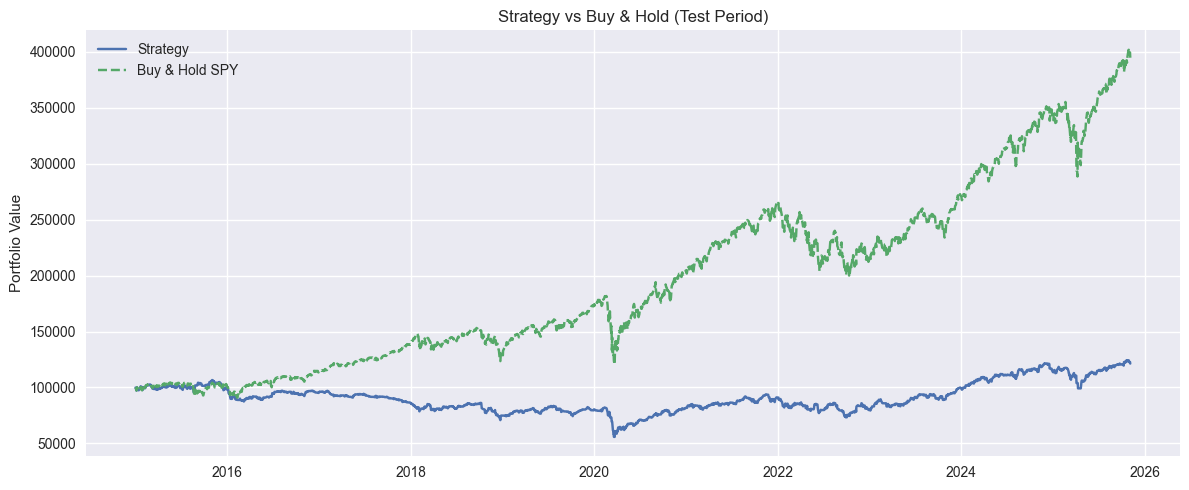

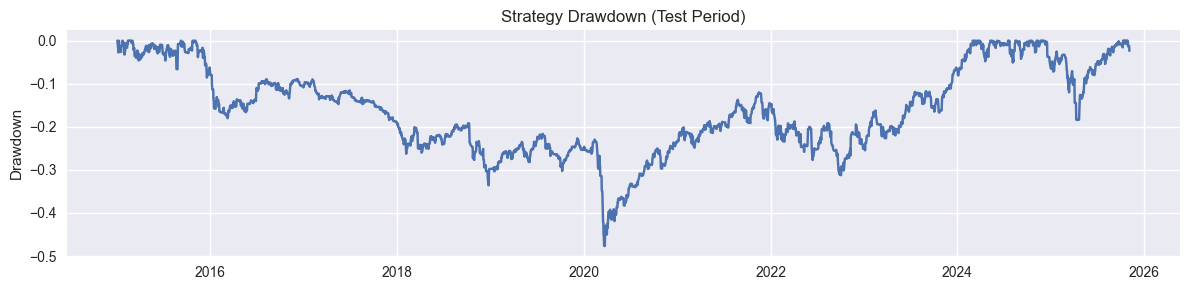

In [20]:
import matplotlib.pyplot as plt

# Get equity curves from vectorbt portfolios
strat_equity = pf.value()      # portfolio equity over time
bh_equity = bh_pf.value()      # buy & hold equity over time

# 1) Equity curves
plt.figure(figsize=(12, 5))
plt.plot(strat_equity.index, strat_equity, label="Strategy")
plt.plot(bh_equity.index, bh_equity, label="Buy & Hold SPY", linestyle="--")
plt.title("Strategy vs Buy & Hold (Test Period)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Drawdowns for the strategy
running_max = strat_equity.cummax()
dd = strat_equity / running_max - 1.0

plt.figure(figsize=(12, 3))
plt.plot(dd.index, dd)
plt.title("Strategy Drawdown (Test Period)")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.show()



## 6. Recap & Extensions

We have implemented a **modular quant research pipeline**:

1. **Data Curation**
   - Downloaded SPY OHLCV from `yfinance`
   - Performed minimal cleaning and renaming

2. **Data Labeling (Triple-Barrier)**
   - Computed daily volatility
   - For each day, set profit-take, stop-loss, and time barrier
   - Assigned labels +1 / −1 / 0 depending on which barrier hit first

3. **Predictive Model**
   - Engineered simple technical features
   - Trained a `RandomForestClassifier` (time-based train/test split)
   - Evaluated classification quality

4. **Strategy Construction**
   - Converted class probabilities into a signal score
   - Mapped score to positions (long/short/flat) using a threshold
   - Shifted positions to avoid look-ahead

5. **Backtesting**
   - Built a simple daily backtest for SPY
   - Computed Sharpe, max drawdown, hit rate
   - Plotted equity curves and drawdowns

---

### Where to go next

For a more advanced / realistic society project, you can extend this notebook by:

- **Multi-asset panel**:
  - Use several ETFs or stocks and do cross-sectional signals and portfolio allocation.
- **More sophisticated labeling**:
  - Full AFML-style triple-barrier with event-based sampling.
- **Richer models**:
  - Gradient boosting, XGBoost, LightGBM, or neural nets (with strict overfitting control).
- **Portfolio construction**:
  - From forecasts to mean-variance optimization, risk parity, or HRP.
- **Transaction costs & execution**:
  - Include spreads, commissions, and impact.
  - Study how turnover affects net performance.
- **Backtesting frameworks**:
  - Port this strategy into `backtesting.py`, `vectorbt`, or a custom engine.

This notebook is intentionally **slightly overfit-friendly** for teaching:
- You see how a model can “look good” historically.
- Later, you can introduce **walk-forward CV**, **purged CV**, and **CPCV** (López de Prado) to show how to fight overfitting.

You can now reuse this as a **template**:
- Swap the labeling, model, or strategy module.
- Keep the overall research workflow intact.


![alt text](image.png)

# Don't give up!